In [11]:
%matplotlib inline

import numpy as np
import pyGM as gm
import os
from pyGM import wmb
from math import exp
import matplotlib.pyplot as plt
datapath = 'data/';
files = os.listdir(datapath)

In [23]:
feature_sizes = [1,2,2,201,201]
ThetaF = [.001*np.random.rand(10,feature_sizes[f]) for f in range(0,len(feature_sizes))];
ThetaP = .001*np.random.rand(10,10);
Loss = 1.0 - np.eye(10); # hamming loss
num_iter = 10;
Lambda = 0.01;
Alpha = 0.01;
accuracy = [];
hinge_loss = [];
# step size, etc.
for iter in range(num_iter):
    cur_hamming = 0;
    num_data = 0;
    cur_hinge = 0;
    for s in range(100):
        # Load data ys,xs
        fh = open(datapath+files[s],'r');
        rawlines = fh.readlines();
        lines = [line.strip('\n').split(',') for line in rawlines];
        fh.close();
        ys = [int(l[1])-1 for l in lines];
        xs = [[int(l[2])-1,int(l[3]),int(l[4]),int(l[5])-1,int(l[6])-1] for l in lines];
        n = len(ys);
        # Define random variables for the inference process:
        Y = [gm.Var(i,10) for i in range(n)];
        #X = [gm.Var(i,feature_sizes[i]) for i in range(0,5)]
        # Build "prediction model" using your parameters
        factors = [gm.Factor([Y[i],Y[i+1]],np.exp(np.exp(ThetaP))) for i in range(0,len(ys)-1)];
        for j in range(n):
            for i in range(0,5):
                factor = gm.Factor([Y[j]],np.exp(np.exp(ThetaF[i][:,xs[j][i]])))
                factors.append(factor);
        # don't forget pyGM expects models to be products of factors,
        # so exponentiate the factors before making a model...
        model_pred = gm.GraphModel(factors);
        # Copy factors and add extra Hamming factors for loss-augmented model
        factors_aug = [ f for f in factors ];
        #factors_aug.extend( [gm.Factor([Y[i]], Loss[:,ys[i]]).exp() for i in range(n)] );
        model_aug = gm.GraphModel(factors_aug);
        order = range(n); # eliminate in sequence (Markov chain on y)
        wt = 1e-4; # for max elimination in JTree implementation
        # Now, the most likely configuration of the prediction model (for prediction) is:
        yhat_pred = wmb.JTree(model_pred,order,wt).argmax();
        # and the maximizing argument of the loss (for computing the gradient) is
        #yhat_aug = wmb.JTree(model_aug,order,wt).argmax();
        yhat_margin = np.log(model.joint());
        
        # use yhat_pred & ys to keep a running estimate of your prediction accuracy & print it
        for i in range(n):
            cur_hamming += (yhat_pred[Y[i]] != ys[i]); 
        num_data += n;
        cur_hinge = cur_hamming;
        for i in range(n):
            for j in range(5):
                cur_hinge += ThetaF[j][yhat_aug[Y[i]],xs[i][j]];
                cur_hinge -= ThetaF[j][ys[i],xs[i][j]];
        for i in range(n-1):
            for j in range(5):
                cur_hinge += ThetaP[yhat_aug[Y[i]]][yhat_aug[Y[i+1]]];
                cur_hinge -= ThetaP[ys[i]][ys[i+1]];
        for i in ThetaF:
            cur_hinge += Lambda * np.sum(np.square(i));
        cur_hinge += Lambda * np.sum(np.square(ThetaP));
        ... # how often etc is up to you
        # use yhat_aug & ys to update your parameters theta in the negative gradient direction
        ThetaP *= (1-Lambda*2*Alpha);
        for f in ThetaF:
            f *= (1-Lambda);
        for i in range(n):
            for j in range(5):
                for k in range(n):
                    ThetaF[j][yhat_aug[Y[i]],xs[i][j]] -= Alpha;
                ThetaF[j][ys[i],xs[i][j]] += Alpha;
        for i in range(n-1):
            ThetaP[yhat_aug[Y[i]]][yhat_aug[Y[i+1]]] -= Alpha;
            ThetaP[ys[i]][ys[i+1]] += Alpha;
    accuracy.append(1-cur_hamming/num_data);
    hinge_loss.append(cur_hinge/len(files));

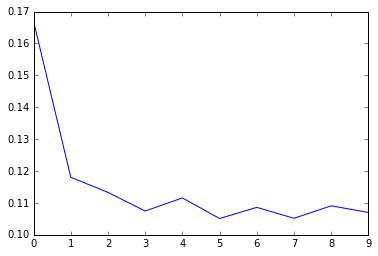

In [24]:
plt.plot(range(len(hinge_loss)),hinge_loss)

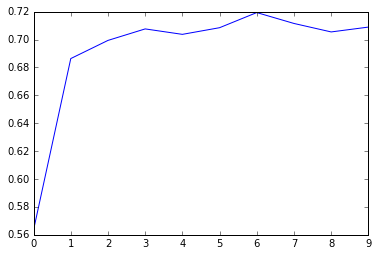

In [25]:
plt.plot(range(len(accuracy)),accuracy)